In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import librosa
import os
import torch.optim as optim
from torch.optim import lr_scheduler
import random

In [2]:
RANDOM_SEED=74
torch.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Audio Preprocessing

In [3]:
def load_file(file_path, duration):
    #LOADS THE FILE 
    audio, sr = librosa.load(file_path, duration=duration)
    
    return audio

In [4]:
def get_spec(audio, hop_size, frame_size):
    spec = librosa.stft(audio, hop_length=hop_size, n_fft=frame_size, window='parzen')
    spec_reals = spec.real
    spec_imag = spec.imag
    spec_reals = spec_reals[np.newaxis, ...]
    spec_imag = spec_imag[np.newaxis, ...]
    data = np.concatenate((spec_reals, spec_imag), axis=0)
    
    return data, spec

In [5]:
def normalise_data(data, amplitude_data):

    sig = np.std(amplitude_data)
    
    #print(sig)
    norm_data = data / sig
    #print(norm_data.shape)
    
    return norm_data, sig

In [6]:
def apply_right_radding(audio_array, size):
    padding = np.array([0 for _ in range(size)])
    audio_array = np.concatenate((audio_array, padding), axis=0)
    
    return audio_array

In [7]:
def denormalize_data(spec, sig):
    original_spec = spec * sig 
    
    return original_spec
    

In [8]:
def freq_to_db(spec):
    real_part = spec[0]
    imag_part = spec[1]
    db_real_spec = librosa.amplitude_to_db(real_part)
    db_imag_spec = librosa.amplitude_to_db(imag_part)
    
    return db_real_spec, db_imag_spec
    

In [9]:
def save_data(data, save_dir, file_name):
    np.save(os.path.join(save_dir, file_name), data)

In [10]:
def preprocess_audio_data(path_to_dir, duration, sr, frame_size, hop_size, save_dir):
    data = []
    data_amplitude = []
    
    for root, _ , files in os.walk(path_to_dir):
        # random.shuffle(files)
        # files = files[:6000]
        for file in tqdm(files):
            path = os.path.join(root, file)
            audio = load_file(path, duration)
            
            if audio.shape[0] < duration * sr:
                size = duration * sr - audio.shape[0]
                audio = apply_right_radding(audio, size)
            
            data_sample, original_spec = get_spec(audio, HOP_SIZE, FRAME_SIZE)
            data.append(data_sample)
#             real_db, imag_db = FreqToDB(data_sample)
#             real_db = real_db[np.newaxis, ...]
#             imag_db = imag_db[np.newaxis, ...]
#             data_sample_db = np.concatenate((real_db, imag_db), axis=0)
            data_amplitude.append(np.abs(original_spec))
            
    data = np.array(data)
    data_amplitude = np.array(data_amplitude)

    
    return data, data_amplitude

In [11]:
def reconstruct_signal(spec, hop_size, frame_size, sig):
    original_spec = spec
    original_spec = denormalize_data(spec, sig)
    original_spec = original_spec[0] + 1j * original_spec[1]
    audio = librosa.istft(original_spec, hop_length=hop_size, n_fft=frame_size, window='parzen')
    return audio

In [12]:
def find_all_dirs(root):
    dirs = []
    for root, direct, files in os.walk(root):
        dirs.append(direct)
    
    return dirs

In [13]:
DURATION = 5
FRAME_SIZE = 1024
HOP_SIZE = 512
SAMPLE_RATE = 22050
PATH_TO_DIR = './udelov_dataset'
SAVE_DIR = './save_dir'

In [14]:
# data, data_amplitude = preprocess_audio_data(PATH_TO_DIR, DURATION, SAMPLE_RATE, FRAME_SIZE, HOP_SIZE, SAVE_DIR)
# data = np.array(data)
# data_amplitude = np.array(data_amplitude)
# data, SIGMA = normalise_data(data, data_amplitude)

In [15]:
# save_data(data, SAVE_DIR, 'udelov_dataset.npy')
# save_data(data_amplitude, SAVE_DIR, 'udelov_data_amplitude.npy')

In [16]:
data_a = np.load(os.path.join(SAVE_DIR, 'krapivin_dataset.npy'))
data_amplitude_a = np.load(os.path.join(SAVE_DIR, 'krapivin_data_amplitude.npy'))
SIGMA_a = np.std(data_amplitude_a)
data_b = np.load(os.path.join(SAVE_DIR, 'udelov_dataset.npy'))
data_amplitude_b = np.load(os.path.join(SAVE_DIR, 'udelov_data_amplitude.npy'))
SIGMA_b = np.std(data_amplitude_b)

In [17]:
data_b.shape

(2554, 2, 513, 216)

In [18]:
data_amplitude_b.shape

(2554, 513, 216)

In [19]:
SIGMA_b

2.2103362

In [20]:
data_a = data_a[:data_b.shape[0]]

# Dataset


In [21]:
class AudioDataset(Dataset):
    def __init__(self, data):
        self.x = torch.from_numpy(data).type(torch.FloatTensor)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, ind):
        return self.x[ind]

In [22]:
from sklearn.model_selection import train_test_split
x_train_a, x_val_a = train_test_split(data_a, test_size=0.2, shuffle=True)
x_train_b, x_val_b = train_test_split(data_b, test_size=0.2, shuffle=True)

In [23]:
x_train_a = AudioDataset(x_train_a)
x_val_a = AudioDataset(x_val_a)
x_train_b = AudioDataset(x_train_b)
x_val_b = AudioDataset(x_val_b)

In [24]:
BATCH_SIZE = 32

train_dataloader_a = DataLoader(x_train_a, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader_a = DataLoader(x_val_a, batch_size=BATCH_SIZE, shuffle=False)
train_dataloader_b = DataLoader(x_train_b, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader_b = DataLoader(x_val_b, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
train_dataloader = [train_dataloader_a, train_dataloader_b]
val_dataloader = [val_dataloader_a, val_dataloader_b]


In [26]:
len(train_dataloader[0])

63

In [27]:
x_train_a.x.shape

torch.Size([2043, 2, 513, 216])

# AutoEncoder Model

In [57]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.norm_distribution = torch.distributions.Normal(0, 1)
        self.kl_loss = 0
        
        self.seq0 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
            nn.LeakyReLU()
        ) 
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU(),
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
            nn.LeakyReLU()
        ) 
        self.seq3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU()
        )
        self.seq4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
            nn.LeakyReLU()
        ) 
        self.seq5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU()
        )
        self.seq6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
            nn.LeakyReLU()
        ) 
        self.seq7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, 
                      kernel_size=(19,3), stride=2, padding=(9,1)),
            nn.LeakyReLU()
        )
        self.mu = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
        )
        self.sigma = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1, 
                      kernel_size=(19,3), stride=1, padding=(9,1)),
        )

            
        
        
    def forward(self, X):
        X = self.seq0(X)
        X = self.seq1(X)
        X = self.seq2(X)
        X = self.seq3(X)
        X = self.seq4(X)
        X = self.seq5(X)
        X = self.seq6(X)
        X = self.seq7(X)
        #Calculate sample Z and KL loss
        mu = self.mu(X)
        sigma = torch.exp(self.sigma(X))
        Z = mu + sigma * self.norm_distribution.sample(mu.shape).to(device)
        self.kl_loss = ((sigma ** 2 + mu ** 2) * 0.5 - torch.log(sigma) - 0.5).sum()
        return Z

In [58]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, output_size):
#         super().__init__()
        
#         self.norm_distribution = torch.distributions.Normal(0, 1)
#         self.kl_loss = 0
        
#         self.seq0 = nn.Sequential(
#             nn.Conv2d(in_channels=2, out_channels=8, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#             nn.LeakyReLU()
#         ) 
#         self.seq1 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, 
#                       kernel_size=(19,3), stride=2, padding=(9,1)),
#             nn.LeakyReLU(),
#         )
#         self.seq2 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#             nn.LeakyReLU()
#         )
#         self.seq3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#             nn.LeakyReLU()
#         )
#         self.mu = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=4, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#         )
#         self.sigma = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=4, 
#                       kernel_size=(19,3), stride=1, padding=(9,1)),
#         )

            
        
        
#     def forward(self, X):
#         X = self.seq0(X)
#         X = self.seq1(X)
#         X = self.seq2(X)
#         X = self.seq3(X)
        
#         #Calculate sample Z and KL loss
#         mu = self.mu(X)
#         sigma = torch.exp(self.sigma(X))
#         Z = mu + sigma * self.norm_distribution.sample(mu.shape).to(device)
#         self.kl_loss = ((sigma ** 2 + mu ** 2) * 0.5 - torch.log(sigma) - 0.5).sum()
#         return Z

In [59]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.seq0 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=1, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )       
        self.seq1 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq2 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq3 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
            nn.LeakyReLU()
        )
        self.seq4 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq5 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
            nn.LeakyReLU()
        )
        self.seq6 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=16, out_channels=16, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0, 0)),
            nn.LeakyReLU()
        )
        self.seq7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, 
                               kernel_size=(19,3), stride=2, padding=(9,1), output_padding=(0, 1)),
            nn.LeakyReLU()
        )
        self.seq8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0,0)),
            nn.LeakyReLU()
        )
        self.conv = nn.ConvTranspose2d(in_channels=4, out_channels=output_size, 
                               kernel_size=(19,3), stride=1, padding=(9,1), output_padding=(0,0))
            
        
        
    def forward(self, X):
        #print('after encoder:', X.shape)
        X = self.seq0(X)
        #print('d_seq0:', X.shape)
        X = self.seq1(X)
        #print('d_seq1:', X.shape)
        X = self.seq2(X)
        #print('d_seq2:', X.shape)
        X = self.seq3(X)
        #print('d_seq3:', X.shape)
        X = self.seq4(X)
        #print('d_seq4:', X.shape)
        X = self.seq5(X)
        #print('d_seq5:', X.shape)
        #print('d_seq5:', X.shape)
        X = self.seq6(X)
        X = self.seq7(X)
        X = self.seq8(X)
        X = self.conv(X)
        #print('result:', X.shape)
        return X

In [60]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, X):
        X = self.encoder(X)
        #print(X.shape)
        return self.decoder(X)

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [62]:
DATA_SAMPLE_SIZE = 2 * 513 * 216
LATENT_SHAPE = 256
encoder = Encoder(input_size=DATA_SAMPLE_SIZE, output_size=LATENT_SHAPE)
encoder.to(device)
decoder_a = Decoder(input_size=LATENT_SHAPE, output_size=2)
decoder_a.to(device)
decoder_b = Decoder(input_size=LATENT_SHAPE, output_size=2)
decoder_b.to(device)
autoencoder_a = AutoEncoder(encoder=encoder, decoder=decoder_a)
autoencoder_a.to(device)
autoencoder_b = AutoEncoder(encoder=encoder, decoder=decoder_b)
autoencoder_b.to(device)


AutoEncoder(
  (encoder): Encoder(
    (seq0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(19, 3), stride=(1, 1), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(19, 3), stride=(1, 1), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq3): Sequential(
      (0): Conv2d(16, 16, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq4): Sequential(
      (0): Conv2d(16, 16, kernel_size=(19, 3), stride=(1, 1), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq5): Sequential(
      (0): Conv2d(16, 16, kernel_size=(19, 3), stride=(2, 2), padding=(9, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (seq6): Sequential(
      (0): Conv2d(16, 16, kernel_size=(19, 3

In [63]:
autoencoder = [autoencoder_a, autoencoder_b]

In [64]:
from torchsummary import summary
summary(autoencoder_a, (2, 513, 216))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 513, 216]             920
         LeakyReLU-2          [-1, 8, 513, 216]               0
            Conv2d-3         [-1, 16, 257, 108]           7,312
         LeakyReLU-4         [-1, 16, 257, 108]               0
            Conv2d-5         [-1, 16, 257, 108]          14,608
         LeakyReLU-6         [-1, 16, 257, 108]               0
            Conv2d-7          [-1, 16, 129, 54]          14,608
         LeakyReLU-8          [-1, 16, 129, 54]               0
            Conv2d-9          [-1, 16, 129, 54]          14,608
        LeakyReLU-10          [-1, 16, 129, 54]               0
           Conv2d-11           [-1, 16, 65, 27]          14,608
        LeakyReLU-12           [-1, 16, 65, 27]               0
           Conv2d-13           [-1, 16, 65, 27]          14,608
        LeakyReLU-14           [-1, 16,

In [65]:
summary(autoencoder_b, (2, 513, 216))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 513, 216]             920
         LeakyReLU-2          [-1, 8, 513, 216]               0
            Conv2d-3         [-1, 16, 257, 108]           7,312
         LeakyReLU-4         [-1, 16, 257, 108]               0
            Conv2d-5         [-1, 16, 257, 108]          14,608
         LeakyReLU-6         [-1, 16, 257, 108]               0
            Conv2d-7          [-1, 16, 129, 54]          14,608
         LeakyReLU-8          [-1, 16, 129, 54]               0
            Conv2d-9          [-1, 16, 129, 54]          14,608
        LeakyReLU-10          [-1, 16, 129, 54]               0
           Conv2d-11           [-1, 16, 65, 27]          14,608
        LeakyReLU-12           [-1, 16, 65, 27]               0
           Conv2d-13           [-1, 16, 65, 27]          14,608
        LeakyReLU-14           [-1, 16,

# Loss-function and optimizer

In [66]:
def MSE_KL_loss(pred, y, kl, batch_size, alpha):
    mse_loss = ((pred - y)**2).sum() / batch_size
    
#     mse_loss = tch_mse(pred, y)
    kl_loss = (kl / batch_size)
    #print('kl:', kl_loss)
    #print('mse:', mse_loss)
    loss = (alpha * kl + ((pred - y)**2).sum()) / batch_size
    #print('loss:', loss)
    return loss, mse_loss, kl_loss

In [67]:
criterion = MSE_KL_loss
optimizer_a = torch.optim.AdamW(autoencoder_a.parameters(), lr=0.001, betas=(0.9, 0.9))
optimizer_b = torch.optim.AdamW(autoencoder_b.parameters(), lr=0.001, betas=(0.9, 0.9))
optimizer = [optimizer_a, optimizer_b]

# Train Loop

In [68]:
# def train(model, criterion, optimizer, alpha,
#           train_dataloader, val_dataloader, num_epochs, n_attempt, prev_best_val_loss=None):
#     if prev_best_val_loss is None:
#         best_val_loss = [torch.inf, torch.inf]
#     else:
#         best_val_loss = prev_best_val_loss

#     log_template = "\nEpoch {ep:03d} Model {model_n:01d} train_loss: {t_loss:0.4f} \
#     val_loss: {v_loss:0.4f} \n mse_train_loss: {mtl:0.4f}  kl_train_loss: {kltl:0.4f} \
#     \n mse_val_loss: {mvl:0.4f}  kl_val_loss: {klvl:0.4f}"

#     train_losses = [np.zeros(num_epochs), np.zeros(num_epochs)]
#     mse_train_losses = [np.zeros(num_epochs), np.zeros(num_epochs)]
#     kl_train_losses = [np.zeros(num_epochs), np.zeros(num_epochs)]
#     val_losses = [np.zeros(num_epochs), np.zeros(num_epochs)]
#     mse_val_losses = [np.zeros(num_epochs), np.zeros(num_epochs)]
#     kl_val_losses = [np.zeros(num_epochs), np.zeros(num_epochs)]
    
    
#     with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
#         for i_epoch in range(num_epochs):
#             for j in range(2):
#                 train_loss = 0
#                 val_loss = 0
#                 mse_train_loss=0
#                 kl_train_loss=0
#                 mse_val_loss=0
#                 kl_val_loss=0

#                 # train step
#                 model[j].train()
#                 for batch in tqdm(train_dataloader[j]):
#                     X = batch.to(device)
#                     # model forward-pass
#                     preds = model[j](X)

#                     # model backward-pass
#                     optimizer[j].zero_grad()
#                     #print(autoencoder.encoder.kl_loss)
#                     loss, mse_loss, kl_loss = criterion(y=X, pred=preds, kl=autoencoder[j].encoder.kl_loss, \
#                                         batch_size=batch.shape[0], alpha=alpha)
#                     #print(loss)
#                     loss.backward()
#                     optimizer[j].step()
#                     # print(f'A{j}: ', autoencoder_a.decoder.seq0[0].weight[0][0][:10])
#                     # print(f'B{j}: ', autoencoder_b.decoder.seq0[0].weight[0][0][:10])

#                     # save loss and accuracy
#                     train_loss += loss.detach().cpu().numpy()
#                     mse_train_loss += mse_loss.detach().cpu().numpy()
#                     kl_train_loss += kl_loss.detach().cpu().numpy()
                        
#                 train_loss /= len(train_dataloader[j])
#                 mse_train_loss /= len(train_dataloader[j])
#                 kl_train_loss /= len(train_dataloader[j])

#                 train_losses[j][i_epoch] = train_loss
#                 mse_train_losses[j][i_epoch] = mse_train_loss
#                 kl_train_losses[j][i_epoch] = kl_train_loss


#                 # test step
#                 model[j].eval()
#                 for batch in val_dataloader[j]:
#                     X = batch.to(device)
#                     #print(X.shape)
#                     with torch.no_grad():
#                         # model forward-pass
#                         preds = model[j](X)
#                         #print(preds.shape)
#                         loss, mse_loss, kl_loss = criterion(y=X, pred=preds, kl=autoencoder[j].encoder.kl_loss, \
#                                         batch_size=batch.shape[0], alpha=alpha)

#                         # save loss and accuracy
#                         val_loss += loss.detach().cpu().numpy()
#                         mse_val_loss += mse_loss.detach().cpu().numpy()
#                         kl_val_loss += kl_loss.detach().cpu().numpy()

#                 val_loss /= len(val_dataloader[j])
#                 mse_val_loss /= len(val_dataloader[j])
#                 kl_val_loss /= len(val_dataloader[j])

#                 val_losses[j][i_epoch] = val_loss
#                 mse_val_losses[j][i_epoch] = mse_val_loss
#                 kl_val_losses[j][i_epoch] = kl_val_loss  

#                 if val_loss < best_val_loss[j]:
#                     best_val_loss[j] = val_loss
                        
#                     torch.save({
#                             'epoch': i_epoch,
#                             'model_state_dict': model[j].state_dict(),
#                             'optimizer_state_dict': optimizer[j].state_dict(),
#                             'loss': val_loss,
#                             'mse_loss': mse_val_loss,
#                             'kl_loss': kl_val_loss,
#                             }, f'best_checkpoint_{j}.pth')
                                    
#                 #Save test_losses and val_losses
#                 np.save(os.path.join(SAVE_DIR, f'train_losses{n_attempt}.npy'), np.array(train_losses))
#                 np.save(os.path.join(SAVE_DIR, f'val_losses{n_attempt}.npy'), np.array(val_losses))
#                 np.save(os.path.join(SAVE_DIR, f'mse_val_losses{n_attempt}.npy'), np.array(mse_val_losses))
#                 np.save(os.path.join(SAVE_DIR, f'kl_val_losses{n_attempt}.npy'), np.array(kl_val_losses))
                                
#                 #Save the last state of the model
#                 torch.save({
#                             'epoch': i_epoch,
#                             'model_state_dict': model[j].state_dict(),
#                             'optimizer_state_dict': optimizer[j].state_dict(),
#                             'loss': val_loss,
#                             'mse_loss': mse_val_loss,
#                             'kl_loss': kl_val_loss,
#                             }, f'last_checkpoint_{j}.pth')
                    
#                 pbar_outer.update(1)
#                 tqdm.write(log_template.format(ep=i_epoch+1, model_n = j, t_loss=train_loss,\
#                                                 v_loss=val_loss, mtl=mse_train_loss, mvl=mse_val_loss, \
#                                                 kltl=kl_train_loss, klvl=kl_val_loss))

#     return train_losses, val_losses, mse_train_losses, kl_train_losses, mse_val_losses, kl_val_losses

In [69]:
def train(model, criterion, optimizer, alpha,
          train_dataloader, val_dataloader, num_epochs, n_attempt, prev_best_val_loss=None):
    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss: {v_loss:0.4f} \n mse_train_loss: {mtl:0.4f}  kl_train_loss: {kltl:0.4f} \
    \n mse_val_loss: {mvl:0.4f}  kl_val_loss: {klvl:0.4f}"

    train_losses = np.zeros(num_epochs)
    mse_train_losses = np.zeros(num_epochs)
    kl_train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    mse_val_losses = np.zeros(num_epochs)
    kl_val_losses = np.zeros(num_epochs)
    
    
    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for i_epoch in range(num_epochs):
            train_loss = 0
            val_loss = 0
            mse_train_loss=0
            kl_train_loss=0
            mse_val_loss=0
            kl_val_loss=0

                # train step
            model[0].train()
            model[1].train()
            for batch0, batch1 in tqdm(zip(train_dataloader[0], train_dataloader[1]), total=len(train_dataloader[0])):
                X0 = batch0.to(device)
                X1 = batch1.to(device)
                # model forward-pass
                preds0 = autoencoder[0](X0)
                preds1 = autoencoder[1](X1)

                # model backward-pass
                optimizer[0].zero_grad()
                optimizer[1].zero_grad()
                #print(autoencoder.encoder.kl_loss)
                loss0, mse_loss0, kl_loss0 = criterion(y=X0, pred=preds0, kl=autoencoder[0].encoder.kl_loss, \
                                    batch_size=batch0.shape[0], alpha=alpha)
                loss1, mse_loss1, kl_loss1 = criterion(y=X1, pred=preds1, kl=autoencoder[1].encoder.kl_loss, \
                                    batch_size=batch1.shape[0], alpha=alpha)
                #print(loss)
                loss = loss0 + loss1
                mse_loss = mse_loss0 + mse_loss1
                kl_loss = kl_loss0 + kl_loss1
                loss.backward()
                optimizer[0].step()
                optimizer[1].step()
                # print(f'A{j}: ', autoencoder_a.encoder.seq0[0].weight[0][0][:10])
                # print(f'B{j}: ', autoencoder_b.encoder.seq0[0].weight[0][0][:10])

                # save loss and accuracy
                train_loss += loss.detach().cpu().numpy()
                mse_train_loss += mse_loss.detach().cpu().numpy()
                kl_train_loss += kl_loss.detach().cpu().numpy()
                    
            train_loss /= (2*len(train_dataloader[0]))
            mse_train_loss /= (2*len(train_dataloader[0]))
            kl_train_loss /= (2*len(train_dataloader[0]))
            train_losses[i_epoch] = train_loss
            mse_train_losses[i_epoch] = mse_train_loss
            kl_train_losses[i_epoch] = kl_train_loss


            # test step
            model[0].eval()
            model[1].eval()
            for batch0, batch1 in zip(val_dataloader[0], val_dataloader[1]):
                X0 = batch0.to(device)
                X1 = batch1.to(device)
                #print(X.shape)
                with torch.no_grad():
                    # model forward-pass
                    preds0 = autoencoder[0](X0)
                    preds1 = autoencoder[1](X1)
                    #print(preds.shape)
                    loss0, mse_loss0, kl_loss0 = criterion(y=X0, pred=preds0, kl=autoencoder[0].encoder.kl_loss, \
                                    batch_size=batch0.shape[0], alpha=alpha)
                    loss1, mse_loss1, kl_loss1 = criterion(y=X1, pred=preds1, kl=autoencoder[1].encoder.kl_loss, \
                                    batch_size=batch1.shape[0], alpha=alpha)

                    # save loss and accuracy
                    loss = loss0 + loss1
                    mse_loss = mse_loss0 + mse_loss1
                    kl_loss = kl_loss0 + kl_loss1
                    val_loss += loss.detach().cpu().numpy()
                    mse_val_loss += mse_loss.detach().cpu().numpy()
                    kl_val_loss += kl_loss.detach().cpu().numpy()

            val_loss /= (2*len(val_dataloader[0]))
            mse_val_loss /= (2*len(val_dataloader[0]))
            kl_val_loss /= (2*len(val_dataloader[0]))

            val_losses[i_epoch] = val_loss
            mse_val_losses[i_epoch] = mse_val_loss
            kl_val_losses[i_epoch] = kl_val_loss  

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                    
                torch.save({
                            'epoch': i_epoch,
                            'model0_state_dict': model[0].state_dict(),
                            'optimizer0_state_dict': optimizer[0].state_dict(),
                            'model1_state_dict': model[1].state_dict(),
                            'optimizer1_state_dict': optimizer[1].state_dict(),
                            'loss': val_loss,
                            'mse_loss': mse_val_loss,
                            'kl_loss': kl_val_loss,
                            }, 'best_checkpoint.pth')
                                
                #Save test_losses and val_losses
            np.save(os.path.join(SAVE_DIR, f'train_losses{n_attempt}.npy'), np.array(train_losses))
            np.save(os.path.join(SAVE_DIR, f'val_losses{n_attempt}.npy'), np.array(val_losses))
            np.save(os.path.join(SAVE_DIR, f'mse_val_losses{n_attempt}.npy'), np.array(mse_val_losses))
            np.save(os.path.join(SAVE_DIR, f'kl_val_losses{n_attempt}.npy'), np.array(kl_val_losses))
                
            #Save the last state of the model
            torch.save({
                        'epoch': i_epoch,
                        'model0_state_dict': model[0].state_dict(),
                        'optimizer0_state_dict': optimizer[0].state_dict(),
                        'model1_state_dict': model[1].state_dict(),
                        'optimizer1_state_dict': optimizer[1].state_dict(),
                        'loss': val_loss,
                        'mse_loss': mse_val_loss,
                        'kl_loss': kl_val_loss,
                        }, 'last_checkpoint.pth')
                
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i_epoch+1, t_loss=train_loss,\
                                            v_loss=val_loss, mtl=mse_train_loss, mvl=mse_val_loss, \
                                            kltl=kl_train_loss, klvl=kl_val_loss))

    return train_losses, val_losses, mse_train_losses, kl_train_losses, mse_val_losses, kl_val_losses

In [70]:
# save_dir = './arch_tests/model2/0.1/best_checkpoint.pth'
# checkpoint = torch.load(save_dir)
# autoencoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# print(epoch, loss)

In [71]:
train_losses, val_losses, mse_train_losses, kl_train_losses, mse_val_losses, kl_val_losses = \
train(model=autoencoder, criterion=criterion, optimizer=optimizer, alpha=0.01,
                                train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=500, n_attempt=1)

epoch:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 001 train_loss: 115053.3769     val_loss: 116675.2080 
 mse_train_loss: 115053.2881  kl_train_loss: 8.9664     
 mse_val_loss: 116675.2080  kl_val_loss: 0.0489


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 002 train_loss: 114690.1193     val_loss: 116671.8799 
 mse_train_loss: 114690.1193  kl_train_loss: 0.0159     
 mse_val_loss: 116671.8799  kl_val_loss: 0.0019


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 003 train_loss: 114945.9645     val_loss: 116671.4297 
 mse_train_loss: 114945.9645  kl_train_loss: 0.0007     
 mse_val_loss: 116671.4297  kl_val_loss: 0.0005


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 004 train_loss: 114859.0193     val_loss: 116671.3276 
 mse_train_loss: 114859.0193  kl_train_loss: 0.0002     
 mse_val_loss: 116671.3276  kl_val_loss: 0.0000


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 005 train_loss: 115042.2231     val_loss: 116671.3110 
 mse_train_loss: 115042.2231  kl_train_loss: 0.0005     
 mse_val_loss: 116671.3110  kl_val_loss: 0.0001


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 006 train_loss: 114872.3077     val_loss: 116671.3203 
 mse_train_loss: 114872.3077  kl_train_loss: 0.0013     
 mse_val_loss: 116671.3203  kl_val_loss: 0.0003


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 007 train_loss: 114905.0946     val_loss: 116671.3809 
 mse_train_loss: 114905.0946  kl_train_loss: 0.0018     
 mse_val_loss: 116671.3809  kl_val_loss: 0.0002


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 008 train_loss: 114969.7716     val_loss: 116671.3843 
 mse_train_loss: 114969.7711  kl_train_loss: 0.0447     
 mse_val_loss: 116671.3843  kl_val_loss: 0.0012


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 009 train_loss: 114744.3929     val_loss: 116671.3447 
 mse_train_loss: 114744.3929  kl_train_loss: 0.0017     
 mse_val_loss: 116671.3447  kl_val_loss: 0.0002


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 010 train_loss: 114866.7861     val_loss: 116671.6172 
 mse_train_loss: 114866.7861  kl_train_loss: 0.0019     
 mse_val_loss: 116671.6172  kl_val_loss: 0.0018


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 011 train_loss: 1988039.3379     val_loss: 116750.3882 
 mse_train_loss: 1987813.6394  kl_train_loss: 22573.2728     
 mse_val_loss: 116745.9980  kl_val_loss: 438.9306


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 012 train_loss: 114873.8392     val_loss: 116689.0195 
 mse_train_loss: 114836.5961  kl_train_loss: 3724.2775     
 mse_val_loss: 116671.6553  kl_val_loss: 1736.1745


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 013 train_loss: 114870.1767     val_loss: 116672.0918 
 mse_train_loss: 114864.7586  kl_train_loss: 541.8862     
 mse_val_loss: 116671.4009  kl_val_loss: 69.1977


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 014 train_loss: 114778.7566     val_loss: 116671.3770 
 mse_train_loss: 114778.5830  kl_train_loss: 17.4091     
 mse_val_loss: 116671.3682  kl_val_loss: 1.1406


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 015 train_loss: 114850.0872     val_loss: 116671.3267 
 mse_train_loss: 114850.0852  kl_train_loss: 0.3486     
 mse_val_loss: 116671.3267  kl_val_loss: 0.0666


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 016 train_loss: 114735.0250     val_loss: 116671.3257 
 mse_train_loss: 114735.0249  kl_train_loss: 0.0638     
 mse_val_loss: 116671.3257  kl_val_loss: 0.0423


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 017 train_loss: 114823.4994     val_loss: 116671.5737 
 mse_train_loss: 114823.4994  kl_train_loss: 0.0207     
 mse_val_loss: 116671.5737  kl_val_loss: 0.0537


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 018 train_loss: 114890.3280     val_loss: 116671.6089 
 mse_train_loss: 114890.3278  kl_train_loss: 0.0723     
 mse_val_loss: 116671.6089  kl_val_loss: 0.0090


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 019 train_loss: 145191.0867     val_loss: 116674.1650 
 mse_train_loss: 145190.5747  kl_train_loss: 51.3474     
 mse_val_loss: 116674.1650  kl_val_loss: 0.0204


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 020 train_loss: 114933.4131     val_loss: 116671.4448 
 mse_train_loss: 114933.4131  kl_train_loss: 0.0795     
 mse_val_loss: 116671.4448  kl_val_loss: 0.1198


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 021 train_loss: 115020.7550     val_loss: 116671.7607 
 mse_train_loss: 115020.7550  kl_train_loss: 0.1213     
 mse_val_loss: 116671.7607  kl_val_loss: 0.1105


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 022 train_loss: 114696.3491     val_loss: 116671.3696 
 mse_train_loss: 114696.3491  kl_train_loss: 0.0984     
 mse_val_loss: 116671.3696  kl_val_loss: 0.0715


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 023 train_loss: 114842.4234     val_loss: 116671.7261 
 mse_train_loss: 114842.4234  kl_train_loss: 0.0490     
 mse_val_loss: 116671.7261  kl_val_loss: 0.1836


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 024 train_loss: 114961.0216     val_loss: 116671.9658 
 mse_train_loss: 114961.0216  kl_train_loss: 0.0286     
 mse_val_loss: 116671.9658  kl_val_loss: 0.0037


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 025 train_loss: 114792.1209     val_loss: 116672.1152 
 mse_train_loss: 114792.1209  kl_train_loss: 0.0085     
 mse_val_loss: 116672.1152  kl_val_loss: 0.0033


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 026 train_loss: 114879.2309     val_loss: 116671.9395 
 mse_train_loss: 114879.1813  kl_train_loss: 4.9827     
 mse_val_loss: 116671.9395  kl_val_loss: 0.1584


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 027 train_loss: 114722.2996     val_loss: 116671.7256 
 mse_train_loss: 114722.2996  kl_train_loss: 0.0254     
 mse_val_loss: 116671.7256  kl_val_loss: 0.0043


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 028 train_loss: 123498.3245     val_loss: 116682.8848 
 mse_train_loss: 123495.9040  kl_train_loss: 242.0175     
 mse_val_loss: 116672.2070  kl_val_loss: 1067.6426


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 029 train_loss: 114925.9368     val_loss: 116672.5913 
 mse_train_loss: 114923.9231  kl_train_loss: 201.3196     
 mse_val_loss: 116672.5308  kl_val_loss: 6.2998


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 030 train_loss: 114704.5201     val_loss: 116672.2729 
 mse_train_loss: 114704.4981  kl_train_loss: 2.2099     
 mse_val_loss: 116672.2637  kl_val_loss: 0.7964


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 031 train_loss: 114826.7144     val_loss: 116672.3477 
 mse_train_loss: 114826.7137  kl_train_loss: 0.1759     
 mse_val_loss: 116672.3398  kl_val_loss: 0.5640


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 032 train_loss: 114794.7340     val_loss: 116672.0508 
 mse_train_loss: 114794.7073  kl_train_loss: 2.6337     
 mse_val_loss: 116672.0508  kl_val_loss: 0.1960


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 033 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 034 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 035 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 036 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 037 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 038 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 039 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 040 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 041 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 042 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 043 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 044 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 045 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 046 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 047 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 048 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 049 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 050 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 051 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 052 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 053 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 054 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 055 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 056 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 057 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 058 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 059 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 060 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 061 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 062 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 063 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 064 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 065 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 066 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 067 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 068 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 069 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 070 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 071 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 072 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 073 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 074 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 075 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 076 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 077 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 078 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 079 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 080 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 081 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 082 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 083 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 084 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]


Epoch 085 train_loss: nan     val_loss: nan 
 mse_train_loss: nan  kl_train_loss: nan     
 mse_val_loss: nan  kl_val_loss: nan


  0%|          | 0/63 [00:00<?, ?it/s]

In [44]:
train_losses1 = np.load(os.path.join(SAVE_DIR, 'train_losses1.npy')) 
val_losses1 = np.load(os.path.join(SAVE_DIR, 'val_losses1.npy'))
mse_losses1 = np.load(os.path.join(SAVE_DIR, 'mse_val_losses1.npy'))
kl_losses1 = np.load(os.path.join(SAVE_DIR, 'kl_val_losses1.npy'))


In [64]:
train_losses2 = np.load(os.path.join(SAVE_DIR, 'train_losses2.npy'))
val_losses2 = np.load(os.path.join(SAVE_DIR, 'val_losses2.npy'))
mse_losses2 = np.load(os.path.join(SAVE_DIR, 'mse_val_losses2.npy'))
kl_losses2 = np.load(os.path.join(SAVE_DIR, 'kl_val_losses2.npy'))

In [69]:
train_losses4 = np.load(os.path.join(SAVE_DIR, 'train_losses4.npy'))
val_losses4 = np.load(os.path.join(SAVE_DIR, 'val_losses4.npy'))

In [45]:
# tl = np.concatenate((train_losses1, train_losses2), axis=1)
# vl = np.concatenate((val_losses1, val_losses2), axis=1)
# ml = np.concatenate((mse_losses1, mse_losses2), axis=1)
# kl = np.concatenate((kl_losses1, kl_losses2), axis=1)
tl = train_losses1
vl = val_losses1
ml = mse_losses1
kl = kl_losses1
tl.shape, vl.shape, ml.shape, kl.shape

((800,), (800,), (800,), (800,))

In [48]:
tl

array([1.14835935e+05, 1.14766111e+05, 1.14753895e+05, 1.14967787e+05,
       1.14740760e+05, 1.14809816e+05, 1.14769102e+05, 1.14839986e+05,
       1.14767781e+05, 1.14773822e+05, 1.14360019e+05, 1.13091040e+05,
       1.12039647e+05, 1.11230469e+05, 1.10420127e+05, 1.09624400e+05,
       1.08646739e+05, 1.07959917e+05, 1.07184592e+05, 1.06382003e+05,
       1.05817109e+05, 1.05252855e+05, 1.04678361e+05, 1.04101588e+05,
       1.03753667e+05, 1.03406978e+05, 1.02976045e+05, 1.02616661e+05,
       1.02203319e+05, 1.02014365e+05, 1.01492724e+05, 1.01248794e+05,
       1.01065827e+05, 1.00797931e+05, 1.00570527e+05, 1.00247662e+05,
       9.98197344e+04, 9.97318074e+04, 9.94937925e+04, 9.91195480e+04,
       9.89331125e+04, 9.86706771e+04, 9.84703919e+04, 9.82123937e+04,
       9.81965321e+04, 9.78441293e+04, 9.76037297e+04, 9.73142088e+04,
       9.71597468e+04, 9.69079205e+04, 9.66323129e+04, 9.65353155e+04,
       9.63576527e+04, 9.61933814e+04, 9.59489559e+04, 9.57148549e+04,
      

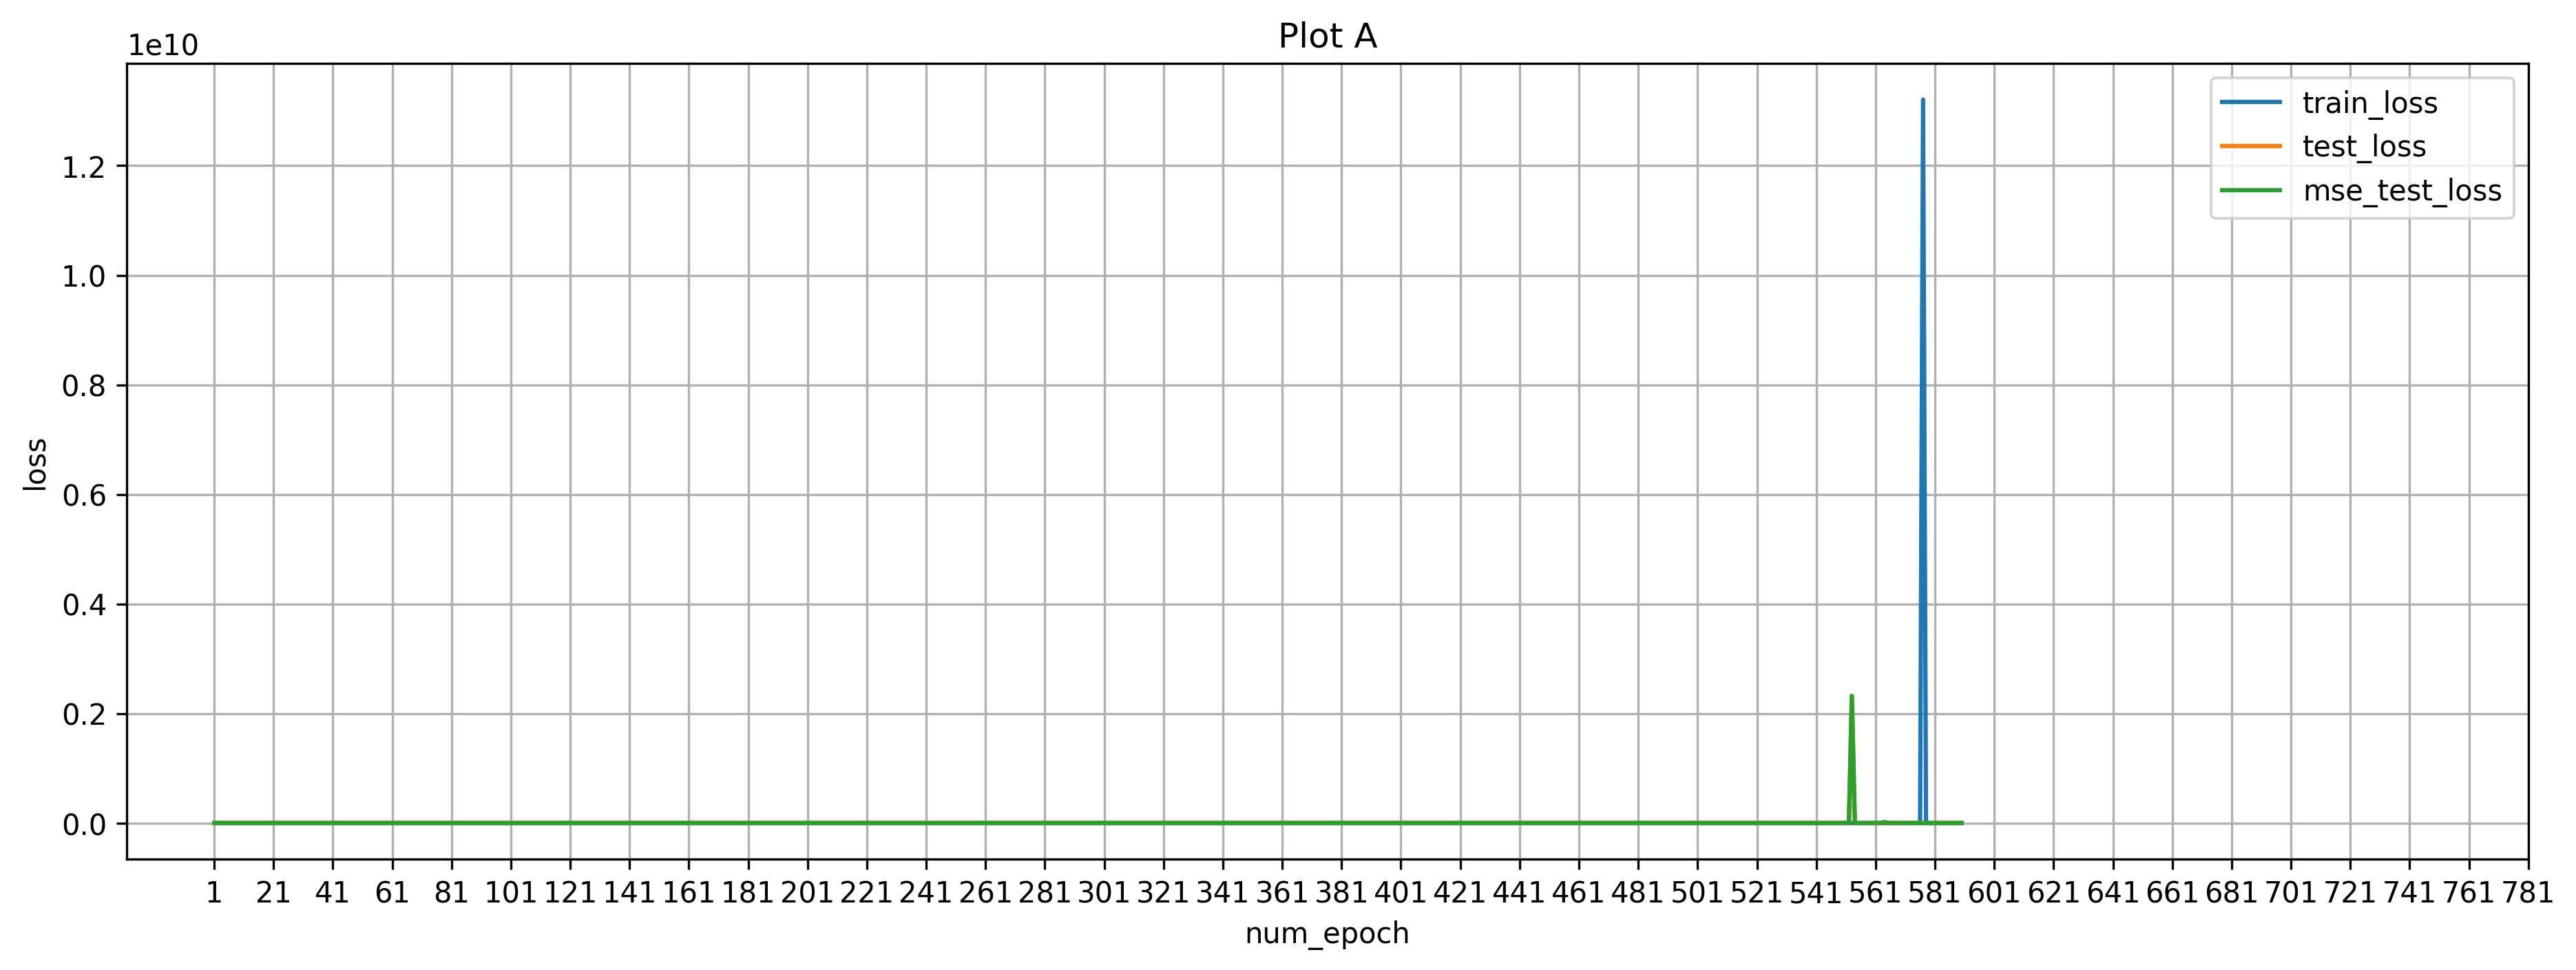

In [47]:
plt.figure(figsize=(15, 5), dpi=300)
plt.plot(np.arange(1, tl.shape[0] + 1), tl, label='train_loss')
plt.plot(np.arange(1, vl.shape[0] + 1), vl, label='test_loss')
plt.plot(np.arange(1, ml.shape[0] + 1), ml, label='mse_test_loss')
#plt.loglog(np.arange(1, kl.shape[0] + 1), kl, label='kl_test_loss')
# plt.loglog(np.arange(1, train_losses.shape[0] + 1), kl_train_losses, label='kl_train_loss')
# plt.loglog(np.arange(1, val_losses.shape[0] + 1), kl_val_losses, label='kl_test_loss')
plt.xticks(np.arange(1, tl.shape[0] + 1, 20))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Plot A')
plt.grid()
plt.show()

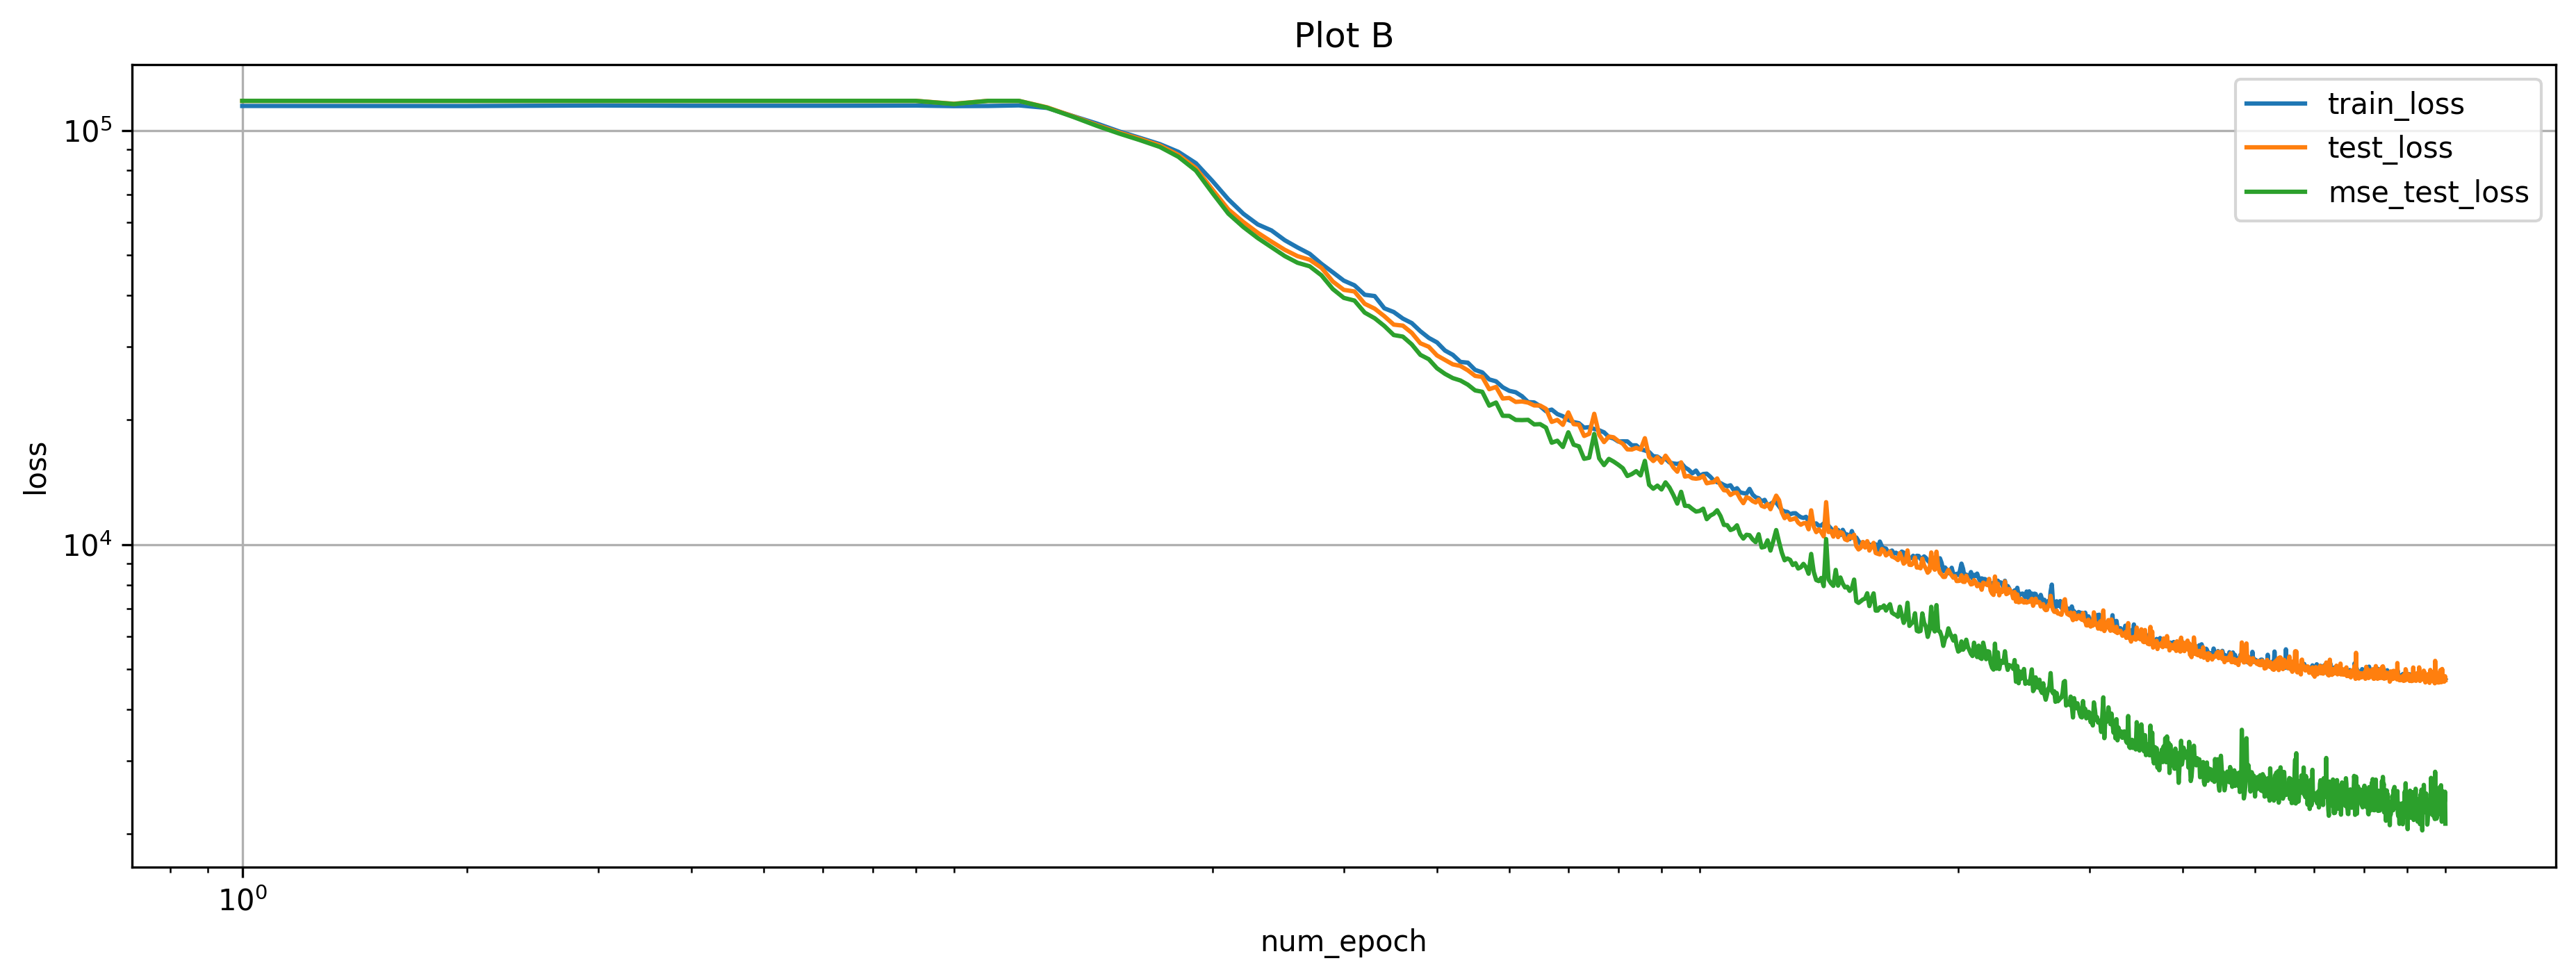

In [70]:
plt.figure(figsize=(15, 5), dpi=300)
plt.loglog(np.arange(1, tl.shape[1] + 1), tl[1], label='train_loss')
plt.loglog(np.arange(1, vl.shape[1] + 1), vl[1], label='test_loss')
plt.loglog(np.arange(1, ml.shape[1] + 1), ml[1], label='mse_test_loss')
#plt.loglog(np.arange(1, kl.shape[0] + 1), kl, label='kl_test_loss')
# plt.loglog(np.arange(1, train_losses.shape[0] + 1), kl_train_losses, label='kl_train_loss')
# plt.loglog(np.arange(1, val_losses.shape[0] + 1), kl_val_losses, label='kl_test_loss')
plt.xticks(np.arange(1, tl.shape[0] + 1, 20))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Plot B')
plt.grid()
plt.show()

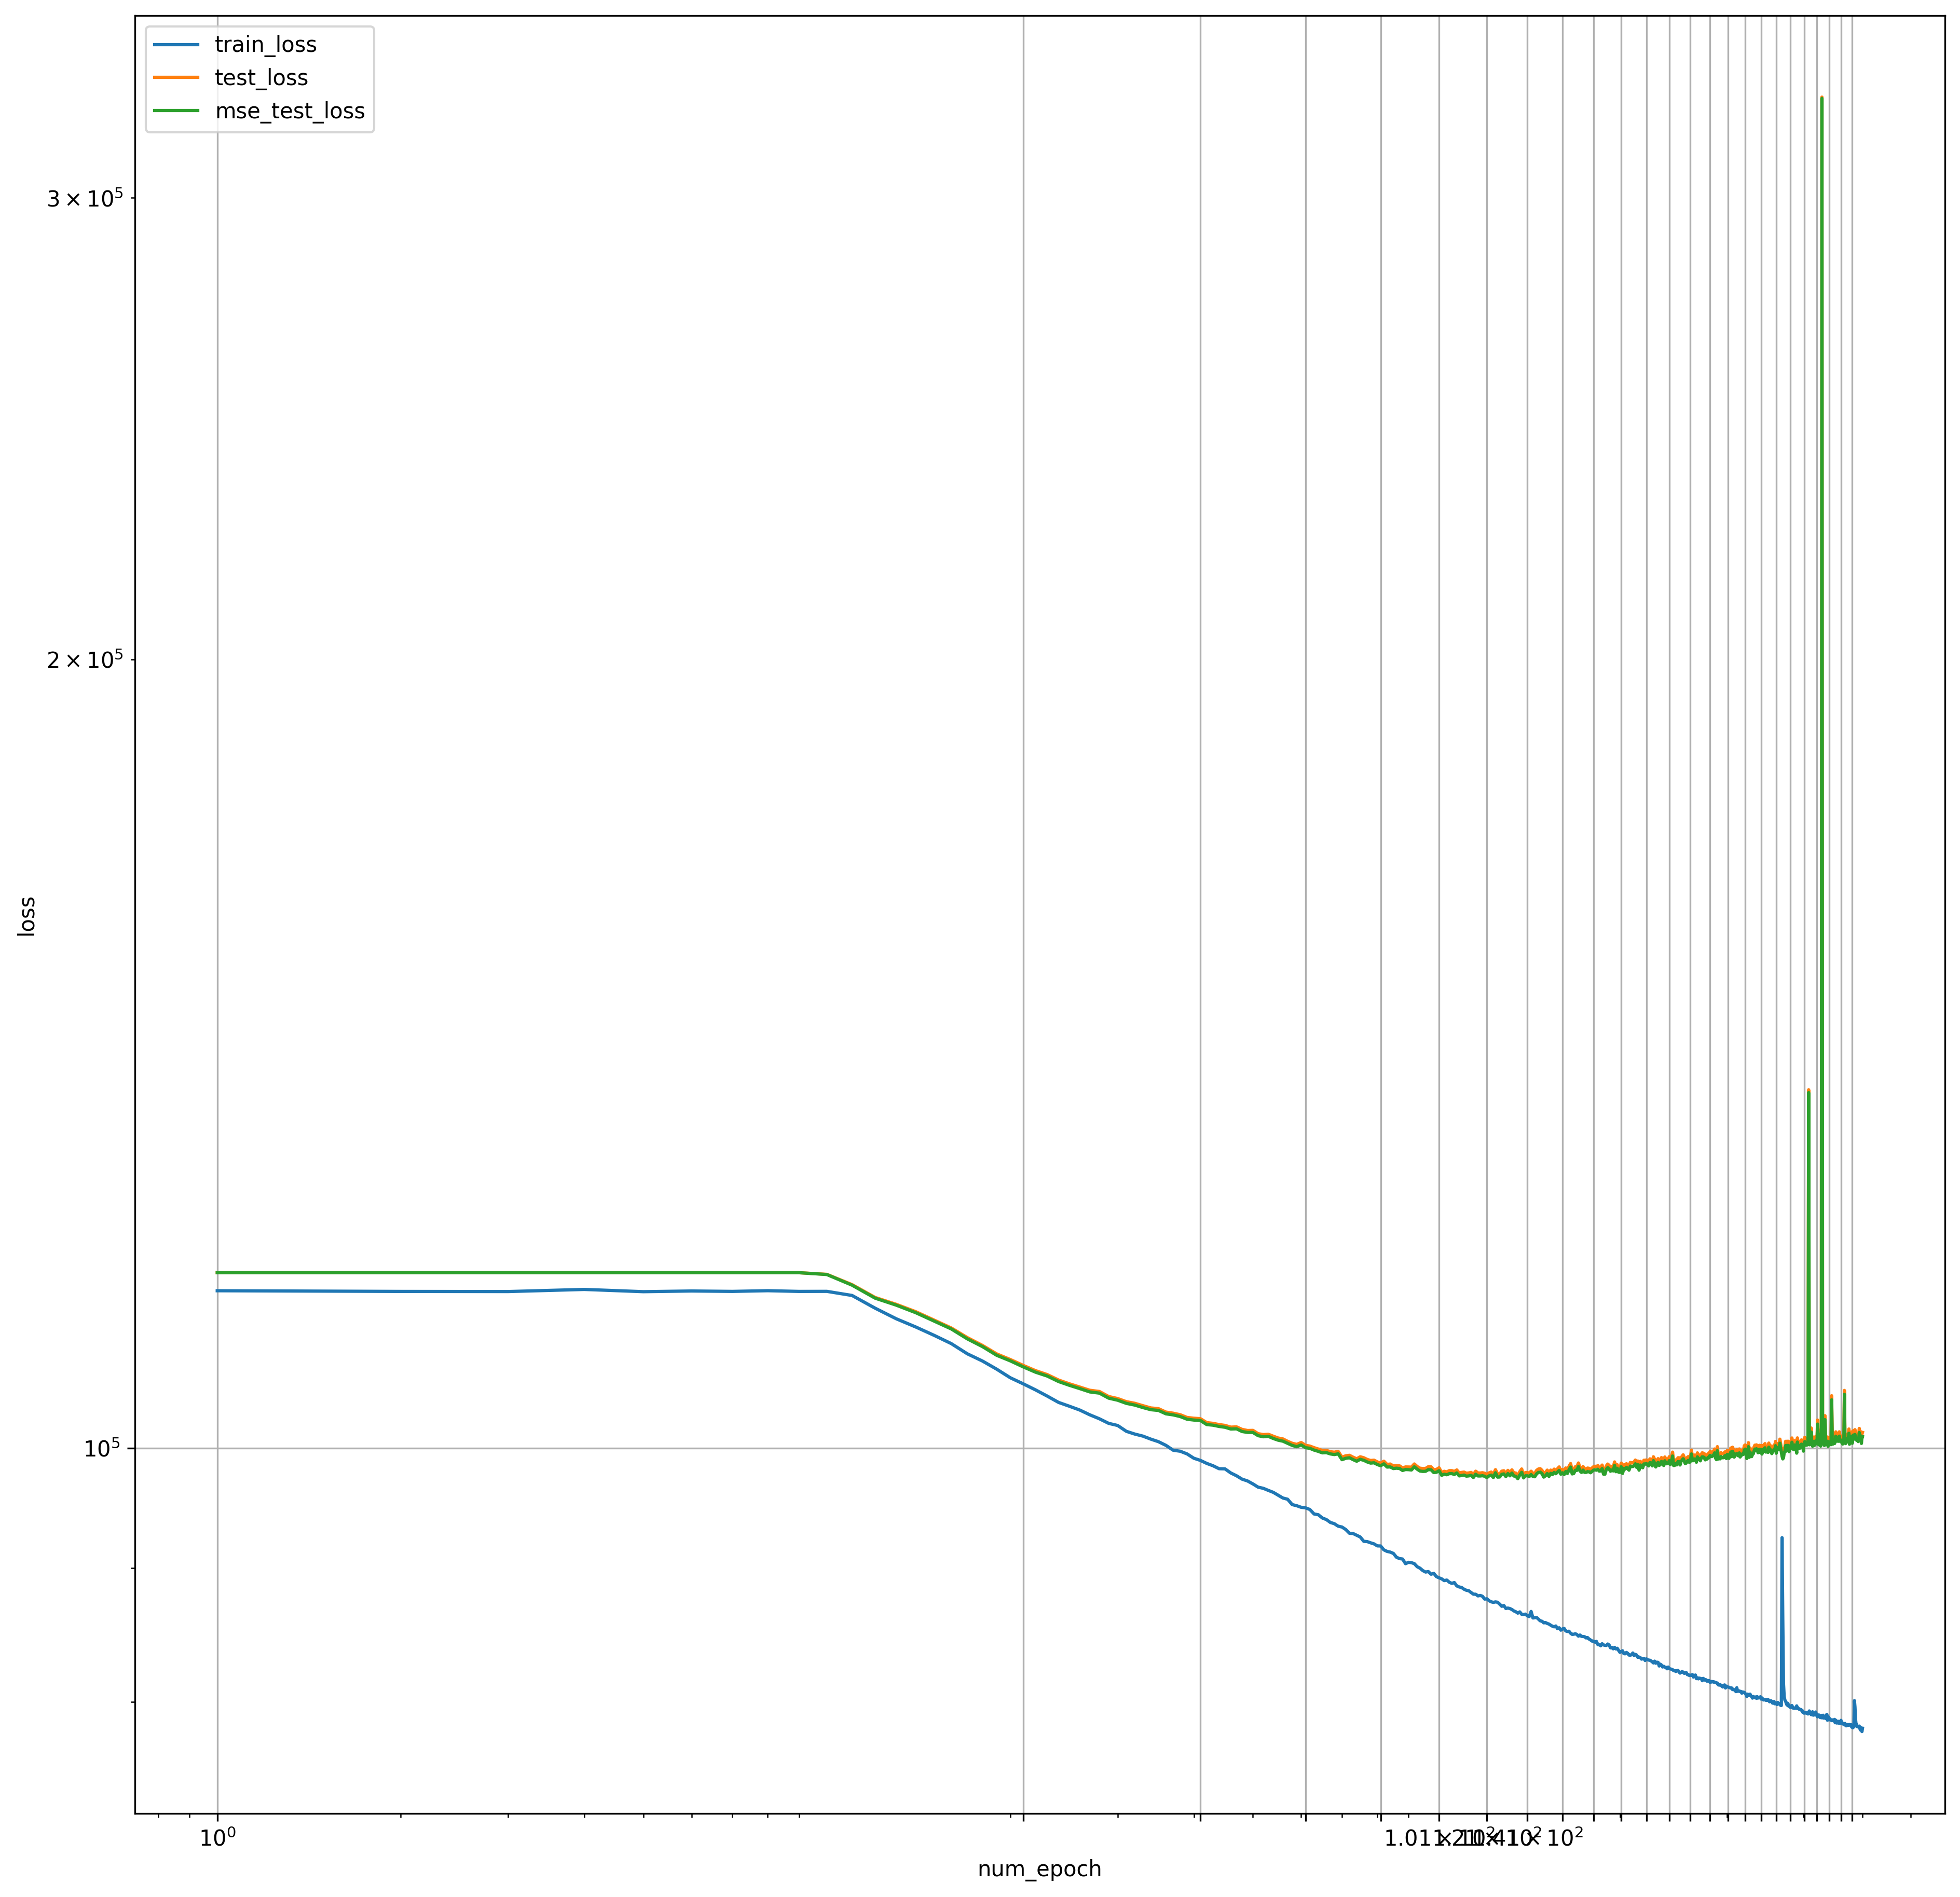

In [51]:
plt.figure(figsize=(15, 15), dpi=300)
plt.loglog(np.arange(1, 501), tl[:500], label='train_loss')
plt.loglog(np.arange(1, 501), vl[:500], label='test_loss')
plt.loglog(np.arange(1, 501), ml[:500], label='mse_test_loss')
plt.xticks(np.arange(1, 501, 20))
#plt.yticks(np.arange(1* 10**3, 5 * 10**3, 500))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

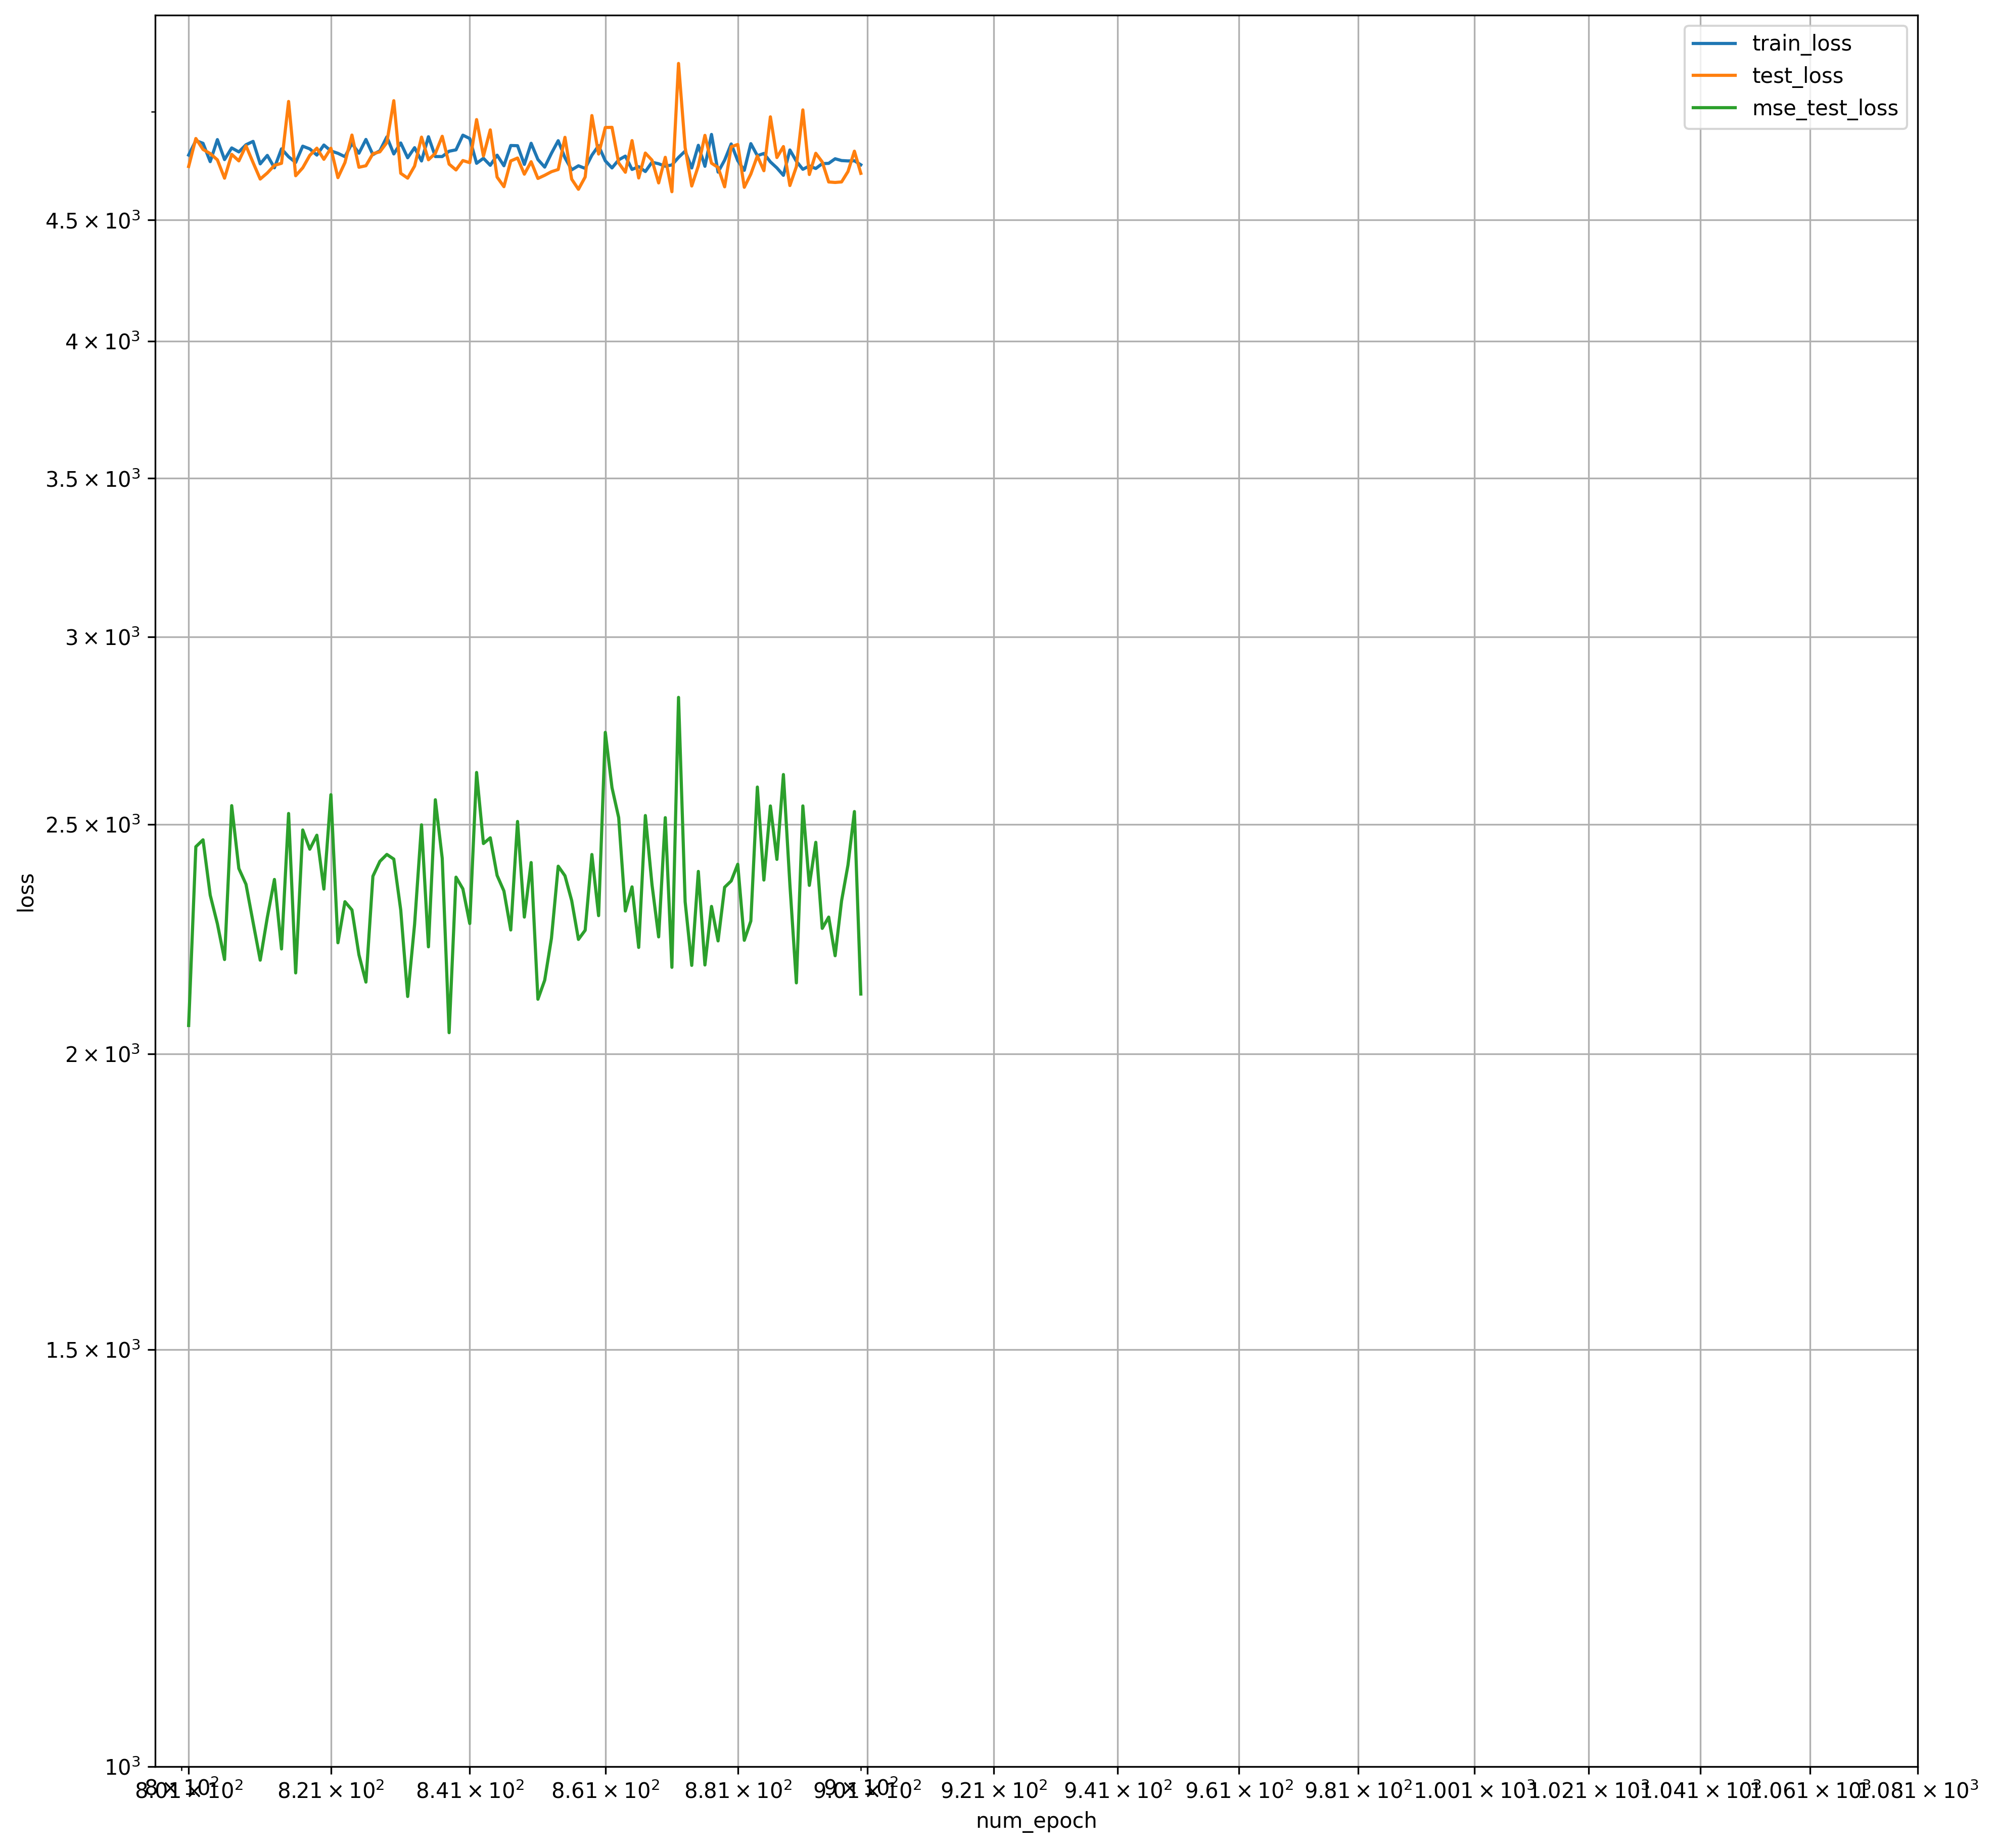

In [85]:
plt.figure(figsize=(15, 15), dpi=300)
plt.loglog(np.arange(801, tl.shape[1] + 1), tl[1][800:], label='train_loss')
plt.loglog(np.arange(801, vl.shape[1] + 1), vl[1][800:], label='test_loss')
plt.loglog(np.arange(801, ml.shape[1] + 1), ml[1][800:], label='mse_test_loss')
plt.xticks(np.arange(801, 1100, 20))
plt.yticks(np.arange(1* 10**3, 5 * 10**3, 500))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# Audio Reconstruction

In [43]:
save_dir = 'best_checkpoint.pth'
checkpoint = torch.load(save_dir)
autoencoder_a.load_state_dict(checkpoint['model0_state_dict'])
autoencoder_b.load_state_dict(checkpoint['model1_state_dict'])
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['mse_loss'], checkpoint['kl_loss'])

135 97606.77197265625 97354.64306640625 2521.276840209961


In [44]:
# save_dir = './VC_models/VC2/best_checkpoint_1.pth'
# checkpoint = torch.load(save_dir)
# autoencoder_b.load_state_dict(checkpoint['model_state_dict'])
# print(checkpoint['epoch'], checkpoint['loss'], checkpoint['mse_loss'], checkpoint['kl_loss'])

In [45]:
from random import randint
test = [randint(0, data_a.shape[0]) for _ in range(5)]
test

[2501, 2110, 465, 1307, 494]

In [46]:
def predict_sample(input_data, model, sig):
    with torch.no_grad():
        model_input = torch.tensor(input_data).type(torch.FloatTensor).unsqueeze(0).to(device)
        pred = model(model_input).squeeze().cpu().numpy()
    audio = reconstruct_signal(spec=pred, hop_size=HOP_SIZE, frame_size=FRAME_SIZE, sig=sig)
    return audio

In [47]:
import IPython.display as ipd
import soundfile as sf

In [48]:
reconstructed_audio = []
original_audio = []
conversed_audio = []
i = 1
for num in tqdm(test):
    r_audio = predict_sample(data_a[num], autoencoder_a, SIGMA_a)
    o_audio = reconstruct_signal(spec=data_a[num], hop_size=HOP_SIZE, frame_size = FRAME_SIZE, sig=SIGMA_a)
    c_audio = predict_sample(data_a[num], autoencoder_b, SIGMA_b)
    reconstructed_audio.append(r_audio)
    original_audio.append(o_audio)
    conversed_audio.append(c_audio)
    sf.write(f'./test_dir/original_file{i}.wav', o_audio, samplerate=SAMPLE_RATE)
    sf.write(f'./test_dir/reconstructed_file{i}.wav', r_audio, samplerate=SAMPLE_RATE)
    sf.write(f'./test_dir/conversed_file{i}.wav', c_audio, samplerate=SAMPLE_RATE)
    i += 1


  0%|          | 0/5 [00:00<?, ?it/s]

In [49]:
ipd.Audio(original_audio[2], rate=SAMPLE_RATE)

In [50]:
ipd.Audio(reconstructed_audio[2], rate=SAMPLE_RATE)

In [51]:
ipd.Audio(conversed_audio[2], rate=SAMPLE_RATE)

In [ ]:
type(original_audio)